<a href="https://colab.research.google.com/github/aissahm/image_analysis/blob/main/FLIM_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
from skimage import segmentation
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch

from skimage import io
from skimage.color import rgb2lab

import sklearn as sklearn
from sklearn import svm
from sklearn import metrics
import random

## **Drawing function**

In [7]:
def drawBandsfromImage(FLIMmultibandimage, nrows, ncols):
  _, axs = plt.subplots(nrows, ncols, figsize=(12, 12))
  axs = axs.flatten()

  npictures = FLIMmultibandimage.shape[1]
  i = 0
  FLIMbandsimage = []
  while i < npictures:
    FLIMbandsimage.append(FLIMmultibandimage[0, i, :])
    i += 1
    
  for FLIMbandimage, ax in zip(FLIMbandsimage, axs):
    ax.imshow(FLIMbandimage)

  plt.show()

def drawImage(imagepath):
  imagetodraw = cv2.imread(imagepath)
  #imgmarker = convertMarkerImageIntoBinaryArray(imgmarker)
  plt.imshow(imagetodraw)

def drawImageMarker(imagepath):
  imagetodraw = cv2.imread(imagepath, 0)
  imagemarker = convertMarkerImageIntoBinaryArray(imagetodraw)
  plt.imshow(imagemarker)

## **Image Color Conversion**

In [8]:
#function that saves an image
def saveImage(image, imagefullpath):
  cv2.imwrite(imagefullpath, image)

#Mapping from grayscale pixel to RGB using color table
def fromGrayscaleToRGBMapping(pixel, H):
  V = pixel / H
  V = (6 - 2) * V + 1
  r_p = H * max(0, (3- abs(V-4) - abs(V-5))/2 )
  g_p = H * max(0, (4- abs(V-2) - abs(V-4))/2 )
  b_p = H * max(0, (3- abs(V-1) - abs(V-2))/2 )
  return [r_p, g_p, b_p]

#Transform the grayscale image with one channel into an RGB image with 3 channels
def fromGrayscaleToRGB(grayscaleimage, bits):
  if len(grayscaleimage.shape) !=2:
    print ("Error: image is not a grayscale image")
    return 0
  
  H = 2**bits -1

  #we initiate an rgb image with 3 channels with same dimensions as grayscale image
  rgbimage = np.zeros((grayscaleimage.shape[0], grayscaleimage.shape[1], 3))
  i = 0
  while i < grayscaleimage.shape[0]:
    j = 0
    while j < grayscaleimage.shape[1]:
      r_p, g_p, b_p = fromGrayscaleToRGBMapping(grayscaleimage[i][j], H)
      rgbimage[i][j][0] = r_p
      rgbimage[i][j][1] = g_p
      rgbimage[i][j][2] = b_p
      
      j +=1
    i +=1
  
  return rgbimage

#Main function that converts a grayscale image with 1 channel to a YCbCr image with 3 channels
def fromGrayscaleToLAB(image, bits):
  rgbimage = fromGrayscaleToRGB(image, bits)
  if len(rgbimage.shape) < 3:
    return 0
  return rgb2lab(rgbimage)

## **Preparing the patches**

In [9]:
#returns mask for corresponding image
def returnMaskPathFromImagePath(imagePath):
  imagePath = imagePath.replace(" ", "")
  return imagePath.replace("orig", "mask") 

#given a text file containing the name of training images return pathfile of respective masks
def returnMaskImagesPathArray(trainTextPath):
  mask_images_path_array = []
  train_images_array = []
  with open(trainTextPath, 'r') as file:
      data = file.read().replace('\n', ';')
      train_images_array = data.split(";")
  for train_image_str in train_images_array:
    mask_image_str = train_image_str.replace("./plates/orig", "/content/plates/mask")
    if len(mask_image_str) > 0:
      mask_images_path_array.append(mask_image_str)

  return mask_images_path_array

#return the subimage of interest
def returnSubimageWith(width, height, xcenter, ycenter, maskImg):
  xstart = xcenter - width//2
  xend = xcenter + width//2
  ystart = ycenter - height//2
  yend = ycenter + height//2
  return maskImg[ystart:yend+1,xstart: xend+1,:]

#returns the number of pixels representing the plate in the mask
def returnPlateNumberPixelsFromMask(maskImg):
  #maskImg = cv2.imread(maskPath)
  return maskImg.sum()/(3*255)

#given width x height, and center coordinates of subimage, returns number of plate pixels contained in subimage
def returnPlateNumberPixelsCovBySubimage(width, height, xcenter, ycenter, maskImg):
  xstart = xcenter - width//2
  if xstart < 0:
    xstart = 0
  xend = xcenter + width//2
  ystart = ycenter - height//2
  if ystart < 0:
    ystart = 0
  yend = ycenter + height//2
  subImg = maskImg[ystart:yend+1,xstart: xend+1,:]

  return subImg.sum()/(3*255)

In [10]:
#creating the folder that will contain the LAB images
os.mkdir("labplates")
directory = '/content/plates/'
labdirectory = "/content/labplates/"

i = 0 
for filename in os.listdir(directory):
  if "orig" in filename:
    grayscaleimg = cv2.imread(directory + filename, cv2.IMREAD_GRAYSCALE)
    labimg = fromGrayscaleToLAB(grayscaleimg, 8)
    labimagepath = labdirectory + filename
    cv2.imwrite(labimagepath, labimg)
    i += 1

print("Done,", i, " images from 'plates/' converted to L*A*B.")

Done, 200  images from 'plates/' converted to L*A*B.


**Super-pixel segmentation**

In [11]:
#returns the Geo center of each super pixel contained in an image
def returnSuperPixelsGeometricCenters(labelimage):
  width = labelimage.shape[1]
  height = labelimage.shape[0]
  nSuperPixels = np.max(labelimage) + 1
  plabelCoordinates = np.zeros(nSuperPixels)

  xCoordinates = np.zeros(nSuperPixels)
  yCoordinates = np.zeros(nSuperPixels)
  nElements = np.zeros(nSuperPixels)

  i = 0
  while i < height:
    j = 0
    while j < width:
      plabel = labelimage[i][j]
      xSum = xCoordinates[plabel]
      ySum = yCoordinates[plabel]
      nLabelElements = nElements[plabel]

      xCoordinates[plabel] = xSum + j
      yCoordinates[plabel] = ySum + i
      nElements[plabel] = nLabelElements + 1  
      j += 1
    i += 1
  
  geocenters = []
  
  plabel = 0
  while plabel < nSuperPixels :
    xCenter = xCoordinates[plabel] / nElements[plabel]
    yCenter = yCoordinates[plabel] / nElements[plabel]
    geocenters.append([int(xCenter), int(yCenter)])
    plabel += 1
  
  return geocenters

#Perform Superpixel segmentation
def returnLabelsWithSuperPixelSegmentation(imagepath, numberSuperpixels):
  originalimage = cv2.imread(imagepath)
  return segmentation.slic(originalimage, n_segments=numberSuperpixels)

In [12]:
#Function that loops through the superpixels number until a plate in subimage is found 
#With threshold 
def returnMinimumSuperpixelsFor(imagepath, numberSuperpixels, width, height, threshold):
  
  subimageWithPlateFound = False

  maskPath = returnMaskPathFromImagePath(imagepath)
  
  maskImage = cv2.imread(maskPath)
  
  nPlatePixelOriginalMask = returnPlateNumberPixelsFromMask(maskImage)
  
  while subimageWithPlateFound == False:
    
    labels = returnLabelsWithSuperPixelSegmentation(imagepath, numberSuperpixels)
    labelsGeocenters = returnSuperPixelsGeometricCenters(labels)

    for labelGeocenter in labelsGeocenters:
      xCenter = labelGeocenter[0]
      yCenter = labelGeocenter[1]
      nPlatePixelsSubimage = returnPlateNumberPixelsCovBySubimage(width, height, xCenter, yCenter, maskImage)
      
      if nPlatePixelsSubimage / nPlatePixelOriginalMask >= threshold:
        subimageWithPlateFound = True
        break

    if subimageWithPlateFound == False:
      numberSuperpixels += 1
      
    #stopping algorithm if number of superpixels is too high
    #then width, height aren't adequate
    if numberSuperpixels > 100 and subimageWithPlateFound == False:
      numberSuperpixels = -1
      break

  return numberSuperpixels 

In this task 3, we reduce the threshold of plates pixels required to classify a subimage as class 1 "plate/foreground". In the previous tasks (1 and 2), we chose a threshold of 90%. In this task, we set the thresold to 50%. That means that every patch that contains just 50% of the plate pixels inside the patch is enough to classify as a "plate/foreground". 

Note: We will have to take that into account when comparing the results with the classifiers we built in the previous tasks.

In [13]:
w = 100 #175 #163
h = 60 #81 #79
thresholdV = 0.5

superpixelsStart = 48

platesFolderPath = "/content/plates/"

f = open("train1.txt", "r")
for imgpath in f:
  imgpath = imgpath.replace("./plates/", "")
  imgpath = imgpath.replace(" ", "")
  imgpath = platesFolderPath + imgpath
  
  if len(imgpath) > 5 and superpixelsStart > 0:
    superpixelsrequired = returnMinimumSuperpixelsFor(imgpath.strip(), superpixelsStart, w, h, thresholdV)
    if superpixelsStart != superpixelsrequired:
      superpixelsStart = superpixelsrequired
      print(imgpath, ": ", superpixelsStart)

**Conclusion:**

Since the treshold is very low, we decided to reduce drastically the size of the patches from the previous tasks. This will decrease dramatically the computations required to process the images too. 

With trials, we found that, with a patch size of 100x60, we require 48 superpixels in order to get at least one patch classified as "plate/foreground" for each image in the three training sets. 

Those parameters will be used in the next steps.

## **Creating the subimages with chosen number of superpixels**

For the task, we use only the training set 1. We evaluate the classifier and compare it to the classifiers built in the previous tasks. 

After that, we select which classifier is the best according to the percentage of plate pixels activated and the percentage of pixels outside the plate deactivated. The higher the scores of the two metrics, the better the model.

Then, we evaluate the consistency of the method on the remaining two training and test sets.

In [14]:
def returnSubimageWIth(width, height, xcenter, ycenter, originalimage):
  xstart = xcenter - width//2
  ystart = ycenter - height//2
  xend = xcenter + width//2
  yend = ycenter + height//2

  if xstart < 0 or ystart < 0:
    print("xcoord or ycoor negative, xstart =",  xstart, ", ystart = ", ystart)
  
  return originalimage[ystart:yend+1,xstart: xend+1,:]

#verifiy the subimage fits inside the original image
def returnCenterCoordinatesSubimageInsideOrigImage(width, height, xcenter, ycenter, W, H):
  if xcenter < width // 2:
    xcenter = width // 2
    
  if xcenter >= W - width//2:
    xcenter = W - width//2 - 1

  if ycenter < height //2:
    ycenter = height //2
  
  if ycenter >= H - height//2:
    ycenter = H - height//2 - 1
  
  return [xcenter, ycenter]

#giving a name for the subimage
def returnSubimageFilename(width, height, xcenter, ycenter, subimageclass, imagepath):
  subimagefilename = imagepath.replace(".png", "")
  subimagefilename = subimagefilename + "_" + str(xcenter) + "_" + str(ycenter) + "_" + str(width) + "_" + str(height) + "_" + str (subimageclass) + ".png"
  return subimagefilename

#returns the subimage characteristics from its name
def returnSubimageDimensionsCenterCoordinates(imagename):
  imagename = imagename.replace(".png", "")
  elementsArray = imagename.split("_")
  imageID = elementsArray[1]
  width = int(elementsArray[4])
  height = int(elementsArray[5])
  xcenter = int(elementsArray[2])
  ycenter = int(elementsArray[3])
  imageclass = int(elementsArray[6])
  return [imageID, width, height, xcenter, ycenter, imageclass]

#returns the class of the subimage depending on the percentage 
#of pixel plates it contains from the original image
def returnSubimageClassWith(nPlatePixelsSubimage, nPlatePixelOriginalMask, platePixelsThreshold):
  if nPlatePixelsSubimage / nPlatePixelOriginalMask >= platePixelsThreshold:
    return 1
  return 0

#creates the subimages with a given number of superpixels
def createSubimagesWithSuperPixelsSegmentation(originalImageFolder, otherformatImageFolder, imagename, subImageFolder, numberSuperpixels, width, height, platePixelsThreshold):
  imagepath = originalImageFolder + imagename
  otherformatimagepath = otherformatImageFolder + imagename
  label = returnLabelsWithSuperPixelSegmentation(imagepath, numberSuperpixels)
  labelsGeocenters = returnSuperPixelsGeometricCenters(label)
  
  maskPath = returnMaskPathFromImagePath(imagepath)
  maskImage = cv2.imread(maskPath)
  nPlatePixelOriginalMask = returnPlateNumberPixelsFromMask(maskImage)
  otherformatOriginalImage = cv2.imread(otherformatimagepath)

  nSubimagesCreated = 0

  W = maskImage.shape[1]
  H = maskImage.shape[0]

  subimageWithClass1 = False

  for labelGeocenter in labelsGeocenters:
    xcenter = labelGeocenter[0]
    ycenter = labelGeocenter[1]

    #we recenter the subimage if needed to fit intside the original image
    #we do that because we need to perform batch norm and we need all subimages with same dimensions
    xcenter, ycenter = returnCenterCoordinatesSubimageInsideOrigImage(width, height, xcenter, ycenter, W, H)
    nPlatePixelsSubimage = returnPlateNumberPixelsCovBySubimage(width, height, xcenter, ycenter, maskImage)
    
    #getting the class of the subimage according to the threshold of plate pixels inside it
    subimageclass = returnSubimageClassWith(nPlatePixelsSubimage, nPlatePixelOriginalMask, platePixelsThreshold)
    
    subimage = returnSubimageWIth(width, height, xcenter, ycenter, otherformatOriginalImage)
    subimagefilename = returnSubimageFilename(width, height, xcenter, ycenter, subimageclass, imagename)
    #saving the subimage
    cv2.imwrite(subImageFolder + subimagefilename, subimage)
    nSubimagesCreated += 1

    if subimageclass == 1:
      subimageWithClass1 = True

  #we verifiy we get at least one subimage containing enough plate pixels
  if subimageWithClass1 == False:
    print("No class 1 for ", imagename)

  return nSubimagesCreated

**Obtaining the LAB patches**

In [15]:
number_superpixels = 48
w = 100 #175 #163
h = 60 #81 #79
thresholdV = 0.5

labPlatesFolder = "/content/labplates/"
platesFolderPath = "/content/plates/"

subimageFoldernameArray = ["lab_train1"]
traintextfilearray = ["train1.txt"]

i = 0
while i < len(traintextfilearray):
  totalSubimagesCreated = 0 
  f = open(traintextfilearray[i], "r")

  os.mkdir(subimageFoldernameArray[i])

  for imgname in f:
    imgname = imgname.replace("./plates/", "")
    imgname = imgname.replace(" ", "")

    if len(imgname) > 5:
      subimagesCreated = createSubimagesWithSuperPixelsSegmentation(platesFolderPath, labPlatesFolder, imgname.strip(), subimageFoldernameArray[i] + "/", number_superpixels, w, h, thresholdV)
      totalSubimagesCreated += subimagesCreated 

  print()
  print(traintextfilearray[i])
  print("Number of subimages created :", totalSubimagesCreated)
  i += 1


train1.txt
Number of subimages created : 3166


**We do the same to obtain the LAB test set.**

In [16]:
number_superpixels = 48
w = 100 #175 #163
h = 60 #81 #79
thresholdV = 0.5

labPlatesFolder = "/content/labplates/"
platesFolderPath = "/content/plates/"

subimageFoldernameArray = ["lab_test1"]
testtextfilearray = ["test1.txt"]

i = 0
while i < len(testtextfilearray):
  totalSubimagesCreated = 0 
  f = open(testtextfilearray[i], "r")

  os.mkdir(subimageFoldernameArray[i])

  for imgname in f:
    imgname = imgname.replace("./plates/", "")
    imgname = imgname.replace(" ", "")

    if len(imgname) > 5:
      subimagesCreated = createSubimagesWithSuperPixelsSegmentation(platesFolderPath, labPlatesFolder, imgname.strip(), subimageFoldernameArray[i] + "/", number_superpixels, w, h, thresholdV)
      totalSubimagesCreated += subimagesCreated 

  print()
  print(testtextfilearray[i])
  print("Number of subimages created :", totalSubimagesCreated)
  i += 1


test1.txt
Number of subimages created : 3206


## **Convert Image Marker to Binary Image**

In [17]:
#function that converts the image marker into a binary array
def convertMarkerImageIntoBinaryArray(markerimage):
  markerimage_width = markerimage.shape[1]
  markerimage_height = markerimage.shape[0]
  markerimagecopy = np.zeros( (markerimage.shape[0], markerimage.shape[1]))
  i = 0
  while i < markerimage_height:
    j = 0
    while j < markerimage_width:
      if markerimage[i][j] < 10:
        markerimagecopy[i][j] = 1
      if markerimage[i][j] < 90 and markerimage[i][j] > 10:
        markerimagecopy[i][j] = 2
      if markerimage[i][j] > 90:
        markerimagecopy[i][j] = 0
      j += 1
    i += 1

  return markerimagecopy

## **Functions to compute scores**

In [18]:
def returnScores(subimage, submask):
  submaskOutsidePlate = submask[:, :, 0].copy() 
  submaskInsidePlate = submask[:, :, 0].copy()

  submaskOutsidePlate[submaskOutsidePlate > 0] = 2 #inside plate is equal to 2
  submaskOutsidePlate[submaskOutsidePlate == 0] = 1 #outside plate is equal to 1
  submaskOutsidePlate[submaskOutsidePlate == 2] = 0 #inside plate is equal to 0

  submaskInsidePlate[submaskInsidePlate > 0] = 1

  subimagecopy = subimage.copy()
  subimagecopy[subimagecopy > 0] = 1
  
  nPlatePixels = np.sum(submaskInsidePlate)
  nActivatedPlatePixels = np.sum(subimagecopy*submaskInsidePlate)

  nDeactivatedPixelsOutsidePlate = np.sum(subimagecopy*submaskOutsidePlate)

  percentagePlatePixelsActivated = -1
  if nPlatePixels > 0:
    percentagePlatePixelsActivated = nActivatedPlatePixels/nPlatePixels
  
  width = submask.shape[1]
  height = submask.shape[0]

  percentageDeactivatedPixelsOutsidePlate = nDeactivatedPixelsOutsidePlate/(width * height - nPlatePixels) 

  return [percentagePlatePixelsActivated, percentageDeactivatedPixelsOutsidePlate]

def computeResultsScores(modelname, modelOutputResult, foldername, maskFolderPath, activationThreshold = 0):
  #
  modelresultsDF = pd.DataFrame(columns = ["Foldername", 'Imagename', "FilterID", 'percentagePlatePixelsActivated', 'percentageDeactivatedPixelsOutsidePlate'])

  for modelOutputResultElem in modelOutputResult:
    imagename = modelOutputResultElem[0]
    imageresult = modelOutputResultElem[1].copy()

    #useful?
    if activationThreshold >= 0:
      imageresult[imageresult <= activationThreshold] = 0
      imageresult[imageresult > activationThreshold] = 1
    else:
      imageresult[imageresult > activationThreshold] = 1
      imageresult[imageresult <= activationThreshold] = 0

    imageID, width, height, xcenter, ycenter, imageclass = returnSubimageDimensionsCenterCoordinates(imagename)
    imagemask = cv2.imread(maskFolderPath + "mask_" + imageID + ".png", 1)
    submask = returnSubimageWith(width, height, xcenter, ycenter, imagemask)

    #getting model scores on image
    index = 0
    while index < imageresult.shape[0]:
      percentagePlatePixelsActivated, percentageDeactivatedPixelsOutsidePlate = returnScores(imageresult[index, :,:], submask)
      modelresultsDF = modelresultsDF.append({"Foldername": foldername,'Imagename' : imagename, 'FilterID' : index+1, 'percentagePlatePixelsActivated' : percentagePlatePixelsActivated, "percentageDeactivatedPixelsOutsidePlate": percentageDeactivatedPixelsOutsidePlate},  
                ignore_index = True)

      index += 1
  
  scoresarray = computeScoresPerKernel(modelresultsDF)
  
  return modelresultsDF

def computeScoresPerKernel(resultsDf):
  nkernelsarray = resultsDf.FilterID.unique()
  pixelsActivatedScoresArray = []
  outsidePlateDeactivatedPixelsScoresArray = []
  FilterIDIDArray = []

  for FilterID in nkernelsarray: 
    kernelPlatePixelsActivatedDf = resultsDf[(resultsDf.FilterID == FilterID ) & (resultsDf.percentagePlatePixelsActivated > -1)].copy()
    kernelOutsidePlateDeactivatedDf = resultsDf[resultsDf.FilterID == FilterID ].copy()
    averageOutsidePixelsDeactivated = kernelOutsidePlateDeactivatedDf.percentageDeactivatedPixelsOutsidePlate.mean()
    averagePlatePixelsActivated = 0
    if kernelPlatePixelsActivatedDf.percentagePlatePixelsActivated.count() > 0:
      averagePlatePixelsActivated = kernelPlatePixelsActivatedDf.percentagePlatePixelsActivated.mean()
    pixelsActivatedScoresArray.append( 100*averagePlatePixelsActivated)
    outsidePlateDeactivatedPixelsScoresArray.append(100*(1- averageOutsidePixelsDeactivated))
    FilterIDIDArray.append("filter_" + str(FilterID))
  
  return [FilterIDIDArray, pixelsActivatedScoresArray, outsidePlateDeactivatedPixelsScoresArray]

#plots the two scores to view results per kernel
def plotScores(titlestr ,modelScoresArray):

  fig, ax = plt.subplots()
  ax.scatter(modelScoresArray[1], modelScoresArray[2])

  print("Scores array ", modelScoresArray)
  plt.title(titlestr)
  plt.xlabel("% activated pixels inside plate region")
  plt.ylabel("% deactivated pixels outside plate region")

  for i, txt in enumerate(modelScoresArray[0]):
      ax.annotate(txt, (modelScoresArray[1][i], modelScoresArray[2][i]))

## **FLIM**

### **Installation**

In [19]:
!unzip "/content/FLIM-dev (2).zip"

!pip install "/content/FLIM-dev/"

!pip install -r "/content/FLIM-dev/requirements.txt"

import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/content/FLIM-dev')

import flim as flim
from flim import utils
from flim.models import lcn

Archive:  /content/FLIM-dev (2).zip
c28006b7cb8cfcce62f0dacc922aa83c79edb9c6
   creating: FLIM-dev/
  inflating: FLIM-dev/.gitignore     
   creating: FLIM-dev/.vscode/
  inflating: FLIM-dev/.vscode/settings.json  
  inflating: FLIM-dev/LICENSE        
  inflating: FLIM-dev/README.md      
  inflating: FLIM-dev/arch.json      
   creating: FLIM-dev/docs/
  inflating: FLIM-dev/docs/Makefile  
  inflating: FLIM-dev/docs/requirements.txt  
   creating: FLIM-dev/docs/source/
   creating: FLIM-dev/docs/source/_autosummary/
  inflating: FLIM-dev/docs/source/_autosummary/flim.models.lcn.rst  
  inflating: FLIM-dev/docs/source/_autosummary/flim.models.rst  
  inflating: FLIM-dev/docs/source/_autosummary/flim.rst  
  inflating: FLIM-dev/docs/source/_autosummary/flim.utils.label_connected_componentes.rst  
  inflating: FLIM-dev/docs/source/_autosummary/flim.utils.rst  
   creating: FLIM-dev/docs/source/_templates/
  inflating: FLIM-dev/docs/source/_templates/custom-class-template.rst  
  inflati

## **Learning the filters from FLIM**

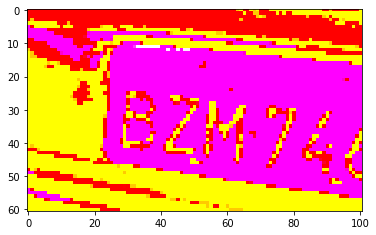

In [20]:
drawImage("/content/original_image.png")

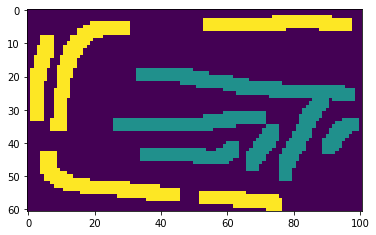

In [21]:
drawImageMarker("/content/image_marker.jpg")

In [22]:
#original image
img = cv2.imread("/content/original_image.png")
print("Pixel intensity range values: ", np.ptp(img))

img = img/(np.array([[116], [500], [200]])).reshape(1, 1, 3)

patches_array = []
patches_array.append(img.astype(np.float32))
patches_array = np.array(patches_array)
patches_array = np.array(patches_array.reshape(patches_array.shape[0], patches_array.shape[1], patches_array.shape[2], patches_array.shape[3]))


#image marker
labelsimg = cv2.imread("/content/image_marker.jpg", 0)
labelsimg = convertMarkerImageIntoBinaryArray(labelsimg)

markers_array = []
markers_array.append(labelsimg)
markers_array = np.array(markers_array)

Pixel intensity range values:  255


In [23]:
architecture = {
    "features": {
        "type": "sequential",
        "layers": {
            "conv": {
                "operation": "conv2d",
                "params": {
                    "kernel_size": 5,
                    "stride": 1,
                    "padding": 2,
                    "dilation": 1,
                    "number_of_kernels_per_marker": 6
                }
            },

            "activation": {
                "operation": "relu",
                "params": {
                    "inplace": True
                }
            },

            "pool": {
                "operation": "max_pool2d",
                "params": {
                    "kernel_size": 3,
                    "stride": 1,
                    "padding": 1
                }
            },

            "norm1": {
                "operation": "batch_norm2d",
                "params": {}
            }

        }
    }
}

In [24]:
lcncreatorinstance = lcn.LCNCreator(architecture, images = patches_array, markers = markers_array, relabel_markers=False)
lcncreatorinstance.build_feature_extractor()

#get model
model = lcncreatorinstance.get_LIDSConvNet()

Building conv
Number of patches 1738
Building activation
Building pool
Building norm1


**Testing on same original image**

output shape : torch.Size([1, 12, 61, 101])


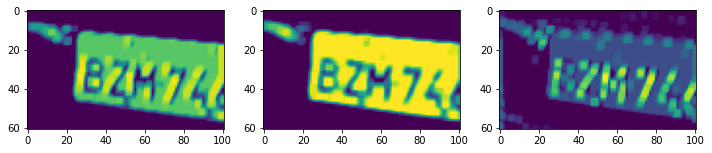

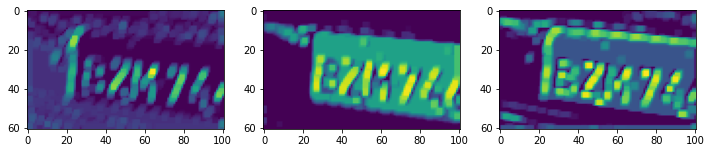

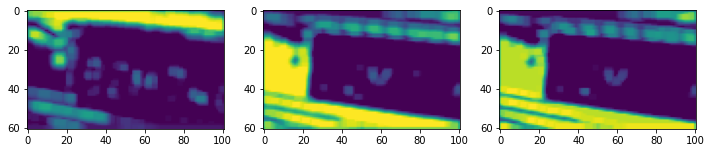

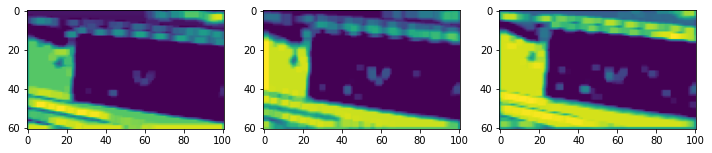

In [25]:
#see output of FLIM
testimg = cv2.imread("/content/original_image.png")

#Normalize 
testimg = testimg/(np.array([[116], [500], [200]])).reshape(1, 1, 3)

testimg = testimg.astype(np.float32)

imgarray = torch.from_numpy(testimg).permute(2, 0, 1).float().unsqueeze(0)

out = model.feature_extractor.forward(imgarray)

print("output shape :", out.shape)

outnumpy = out.detach().numpy()

n_row = 1
n_col = 3

#drawing the bands obtained from FLIM
drawBandsfromImage(outnumpy[:, 0:3, :, :], n_row, n_col)
drawBandsfromImage(outnumpy[:, 3:6, :, :], n_row, n_col)
drawBandsfromImage(outnumpy[:, 6:9, :, :], n_row, n_col)
drawBandsfromImage(outnumpy[:, 9:12, :, :], n_row, n_col)
#drawBandsfromImage(outnumpy[:, 12:15, :, :], n_row, n_col)
#drawBandsfromImage(outnumpy[:, 15:18, :, :], n_row, n_col)
#drawBandsfromImage(outnumpy[:, 18:21, :, :], n_row, n_col)
#drawBandsfromImage(outnumpy[:, 21:24, :, :], n_row, n_col)

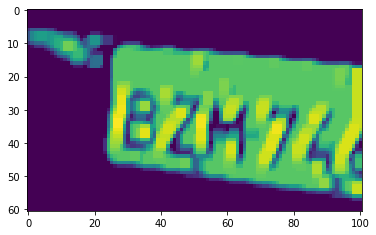

In [26]:
plt.imshow(outnumpy[0,0,:,:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


output shape : torch.Size([1, 6, 61, 101])


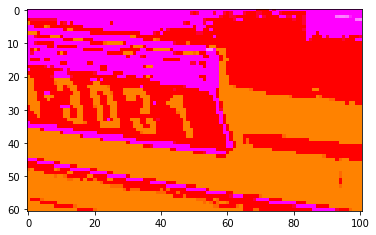

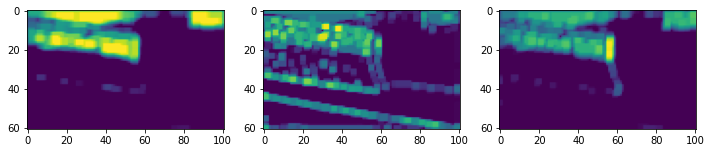

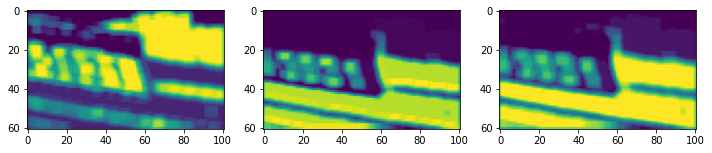

In [90]:
#see output of FLIM
testimg = cv2.imread("/content/lab_train1/orig_0003_233_178_100_60_1.png")

#Normalize 
testimg = testimg/(np.array([[116], [500], [200]])).reshape(1, 1, 3)

testimg = testimg.astype(np.float32)

imgarray = torch.from_numpy(testimg).permute(2, 0, 1).float().unsqueeze(0)

out = model.feature_extractor.forward(imgarray)

print("output shape :", out.shape)

outnumpy = out.detach().numpy()

n_row = 1
n_col = 3

#drawing the bands obtained from FLIM
plt.imshow(testimg)
drawBandsfromImage(outnumpy[:, 0:3, :, :], n_row, n_col)
drawBandsfromImage(outnumpy[:, 3:6, :, :], n_row, n_col)

**Conclusion:**

From the results above, we can clearly see a large improvement from haar-like features in task 2. 

We use FLIM to learn filters from two classes, "plate/foreground" and "no plate/ background".

Through various experiments, we run FLIM with varying numbers of filters, from 3 filter/class to 64/class. Since the results were visually similar, and to reduce the number of computations to make this solution even more effective, we finally decide to run FLIM to learn 3 filters from each class. 

In the next section, we get the output from all the patches contained in traning set 1 and then, we precisely compute the improvements obtained from FLIM compared to haar-like features, from task 2.

## **Getting the output from FLIM on all patches in train set 1**

In [27]:
#function that returns the output from the FLIM model
def returnOutputFromFLIMForPatch(inputimage, FLIMmodel):
  #Normalize 
  inputimage = inputimage/(np.array([[116], [500], [200]])).reshape(1, 1, 3)
  inputimage = inputimage.astype(np.float32)
  imgarray = torch.from_numpy(inputimage).permute(2, 0, 1).float().unsqueeze(0)
  out = FLIMmodel.feature_extractor.forward(imgarray)
  FLIMoutput = out.detach().numpy()
  return FLIMoutput[0]

In [28]:
foldername = "/content/lab_train1/"

FLIMmodelBatchOutput = []

for imagename in os.listdir(foldername):
    subimage = cv2.imread(foldername + imagename)
    FLMIMultiBandImage = returnOutputFromFLIMForPatch(subimage, model)
    FLIMmodelBatchOutput.append([imagename, FLMIMultiBandImage])

##**Selecting the filters learned by FLIM**

In this section, we select computationnaly the best filters obtained in the previous section, learned and obtained by FLIM. This will also allow us to measure the improvements from haar-like features.

Scores array  [['filter_1', 'filter_2', 'filter_3', 'filter_4', 'filter_5', 'filter_6'], [49.09161106009531, 35.10248952992738, 50.963860128139615, 2.9654068761894177, 0.41483573669136853, 0.3482570901312392], [92.3467758746093, 91.04010022740631, 92.71458580257772, 87.68700255539491, 89.69772326671847, 89.67348401267576]]


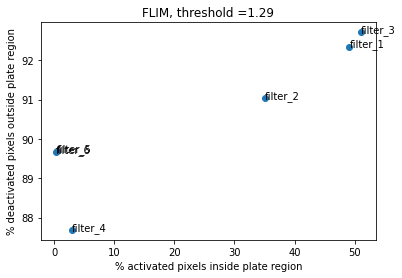

In [86]:
#FLIMResultsDF = computeResultsScores(modelname, modelOutputResult, foldername, maskFolderPath, activationThreshold = 0)

foldername = "lab_train1"
maskFolderPath = "/content/plates/"

activationThresholdValue = 1.29

titlestring = "FLIM, threshold =" + str(activationThresholdValue)
dfresults = computeResultsScores("FLIM", FLIMmodelBatchOutput, foldername, maskFolderPath, activationThresholdValue)
scoresarray = computeScoresPerKernel(dfresults)
plotScores(titlestring, scoresarray)

## **Train SVM to classify patches**

**Flattening the multiband patches into one feature vector**

In [63]:
def flattenImage(mbandsimage):
  mbands = len(mbandsimage)
  i = 0
  onefeaturevector = []
  while i < mbands:
    bandimage = mbandsimage[i]
    #bandimage = sklearn.preprocessing.normalize(bandimage)
    onefeaturevector.append( bandimage.flatten())
    i += 1
  onefeaturevector = np.array(onefeaturevector)
  return onefeaturevector.flatten()

#returns a training set composed of plates/no plates patches, given a ratio of plates to no plates
def returnTrainingSet(FLIMBatch, selectedBandsArray, validationSetPercentageSize = 0.1):
  
  xplate = []
  xnoplate = []

  if len(selectedBandsArray) == 0:
    totalnumberBands = FLIMBatch[0][1].shape[0]
    selectedBandsArray = list(range(0, totalnumberBands))

  for FLIMoutputElem in FLIMBatch:
    FLIMimagename = FLIMoutputElem[0]
    imageID, width, height, xcenter, ycenter, yElem = returnSubimageDimensionsCenterCoordinates(FLIMimagename)
    xElem = []
    for index in selectedBandsArray:
      xElem.append( FLIMoutputElem[1][index,:,:])
    if yElem == 1:
      xplate.append(flattenImage(xElem))
    else:
      xnoplate.append(flattenImage(xElem))

  numberPlatePatches = len(xplate)
  #numberNoPlatePatches = len(xnoplate)

  numNoPlatePatchesSamples = int(ratioPlateNoPlatePatches * numberPlatePatches)

  x_sample_noplate = random.sample(xnoplate, numNoPlatePatchesSamples)

  xtrain = xplate + x_sample_noplate
  ytrain = [1] * numberPlatePatches + [0] * len(x_sample_noplate)

  return [xtrain, ytrain]

#returns a training set composed of plates/no plates patches, given a ratio of plates to no plates
def returnTrainingValidationSets(FLIMBatch, selectedBandsArray, validationSetPercentageSize = 0.1):
  
  if len(selectedBandsArray) == 0:
    totalnumberBands = FLIMBatch[0][1].shape[0]
    selectedBandsArray = list(range(0, totalnumberBands))

  platesPatchesObject = {}
  noPlatesPatchesObject = {}

  for FLIMoutputElem in FLIMBatch:
    FLIMimagename = FLIMoutputElem[0]
    imageID, width, height, xcenter, ycenter, elemClass = returnSubimageDimensionsCenterCoordinates(FLIMimagename)
    xElem = []
    for index in selectedBandsArray:
      xElem.append( FLIMoutputElem[1][index,:,:])
    
    #No plate class
    if elemClass == 0:
      if hasattr(noPlatesPatchesObject, imageID):
        noPlatesPatchIDcurrentList = noPlatesPatchesObject[imageID]
        noPlatesPatchIDcurrentList.append(flattenImage(xElem))
        noPlatesPatchesObject[imageID] = noPlatesPatchIDcurrentList
      else:
        noPlatesPatchesObject[imageID] = []
        noPlatesPatchesObject[imageID].append(flattenImage(xElem))
    #plate class
    else:
      if hasattr(platesPatchesObject, imageID):
        platesPatchIDcurrentList = platesPatchesObject[imageID]
        platesPatchIDcurrentList.append(flattenImage(xElem))
        platesPatchesObject[imageID] = platesPatchIDcurrentList
      else:
        platesPatchesObject[imageID] = []
        platesPatchesObject[imageID].append(flattenImage(xElem))

  #get the number of different patch IDs to split the set into train/validation sets
  numPatches = len(platesPatchesObject)
  validationSetSize = int(validationSetPercentageSize * numPatches) + 1
  trainSetSize = numPatches - validationSetSize

  #we select randomly patch IDs to form the training set
  #we pick the same number of class 1 and class 0 patches for the same patch ID
  #if there is only one patch classified as "plate", then one patch classified as "no patch" will be selected as well, with the same patchID
  #this is to keep the number of data inside the two class balanced
  trainSetrandomPatchIDsList =  random.sample(list(platesPatchesObject), trainSetSize)

  xtrain = []
  ytrain = []
  xvalidation = []
  yvalidation = []

  for patchID in list(platesPatchesObject):
    #patchID selected to be in train set  
    if patchID in trainSetrandomPatchIDsList:
      patchIDImages = platesPatchesObject[patchID]
      numberImages = len(patchIDImages)
      xtrain = xtrain + patchIDImages
      ytrain = ytrain + [1] * numberImages
      xtrain = xtrain + random.sample(noPlatesPatchesObject[patchID], numberImages)
      ytrain = ytrain + [0] * numberImages
    else:
      #patch ID goes into validation set
      patchIDImages = platesPatchesObject[patchID]
      numberImages = len(patchIDImages)
      xvalidation = xvalidation + patchIDImages
      yvalidation = yvalidation + [1] * numberImages
      xvalidation = xvalidation + random.sample(noPlatesPatchesObject[patchID], numberImages)
      yvalidation = yvalidation + [0] * numberImages

  return [yvalidation, xvalidation, ytrain, xtrain]

In [60]:
dic = {}
x = "8"
for i in range(6):
    #calculate x
    dic[i] = int(str(x)+str(i))

print(dic)
print(list(dic))

random.choice(list(dic))


{0: 80, 1: 81, 2: 82, 3: 83, 4: 84, 5: 85}
[0, 1, 2, 3, 4, 5]


3

**We select which bands to include in the training set and prepare the training set to train SVM**

In [64]:
validation_set_Percentage_size = 0.1

selected_Bands_Array = []

y_validation, x_validation, y_train, x_train = returnTrainingValidationSets(FLIMmodelBatchOutput, selected_Bands_Array, validation_set_Percentage_size)


In [65]:
#Create a svm Classifier
clf = svm.SVC(kernel='linear', C= 10**2) # Linear Kernel

clf.fit(x_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(x_validation)

In [66]:
print("Accuracy:",metrics.accuracy_score(y_validation, y_pred))

Accuracy: 0.8181818181818182


In [68]:
foldername = "/content/lab_test1/"

TestFLIMmodelBatchOutput = []

for imagename in os.listdir(foldername):
    subimage = cv2.imread(foldername + imagename)
    FLMIMultiBandImage = returnOutputFromFLIMForPatch(subimage, model)
    TestFLIMmodelBatchOutput.append([imagename, FLMIMultiBandImage])

x_lab_test = []
y_lab_test = []

if len(selected_Bands_Array) == 0:
    totalnumberBands = TestFLIMmodelBatchOutput[0][1].shape[0]
    selected_Bands_Array = list(range(0, totalnumberBands))

for FLIMoutputElem in TestFLIMmodelBatchOutput:
    FLIMimagename = FLIMoutputElem[0]
    imageID, width, height, xcenter, ycenter, yElem = returnSubimageDimensionsCenterCoordinates(FLIMimagename)
    xElem = []
    for index in selected_Bands_Array:
      xElem.append( FLIMoutputElem[1][index,:,:])
    
    x_lab_test.append(flattenImage(xElem))
    y_lab_test.append(yElem)

In [69]:
#Predict the accuracy score for the test dataset 1
y_lab_test1_pred = clf.predict(x_lab_test1)

print("Accuracy:",metrics.accuracy_score(y_lab_test1, y_lab_test1_pred))

Accuracy: 0.8348423353106462


## **Selecting the size of the rectangle to identify the plate**

In this section, we want to find the smallest rectangle that contains the largest plate, among the plates contained in a training set.

Since we won't expect that it would fit perfectly on the test set, using the classification FLIM+SVM, we will enlarge that rectangle, with a percentage increase that will be determined in the experiment conducted on the training set.

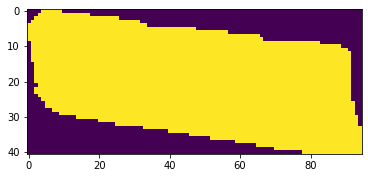

In [100]:
imgtest = cv2.imread("/content/plates/mask_0003.png", 0)

plt.imshow(imgtest[150:191,149:244 ])

In [101]:
def returnExtremeCoordinatesFrom(imageMaskPath):
  maskImage = cv2.imread(imageMaskPath, 0)
  i = 0
  maskwidth = maskImage.shape[1]
  maskheight = maskImage.shape[0]
  xmin = maskwidth
  xmax = 0
  ymin = maskheight
  ymax = 0
  while i < maskheight:
    j = 0
    while j < maskwidth:
      if maskImage[i][j] > 0 and j <= xmin:
        xmin = j
      if maskImage[i][j] > 0 and j >= xmax:
        xmax = j
      if maskImage[i][j] > 0 and i <= ymin:
        ymin = i
      if maskImage[i][j] > 0 and i >= ymax:
        ymax = i
      j += 1
    i += 1
  
  return [ymax, ymin, xmax, xmin]

#function that returns the minimum rectangle size to delimit the 
#plate inside the original image
def returnMinimumRectangleSize(imagesFoldername, maskFoldername):

  f = open(imagesFoldername, "r")
  
  maxwidth = 0
  maxheight = 0

  for imagePath in f:
    imagePath = imagePath.replace("./plates/", "")
    imagePath = imagePath.replace(" ", "")
    imagePath = imagePath.replace("orig", "mask")
    imagePath = maskFoldername + imagePath
    
    if len(imagePath) > 5:
      ymax, ymin, xmax, xmin = returnExtremeCoordinatesFrom(imagePath.strip())
      if ymax - ymin >  maxheight:
        maxheight = ymax - ymin
      if xmax - xmin > maxwidth:
        maxwidth = xmax - xmin 
    
  return [maxheight, maxwidth]

In [102]:
returnMinimumRectangleSize("/content/train1.txt", "/content/plates/")

[57, 112]

## **Determining the region found by FLIM+SVM, using the patches classified as plates by SVM**

In [ ]:
def returnRegionCenterCoordinates(patchesBatchSet, SVMPatchesBatchSetClassification):


## **Bear image: Structuring the inputs for FLIM**

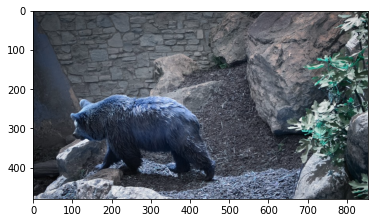

In [ ]:
drawImage("/content/00000.jpg")

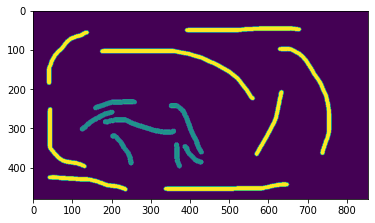

In [ ]:
drawImageMarker("/content/00000marked.jpg")

In [ ]:
#original image
img = cv2.imread("/content/00000.jpg")
print("Pixel intensity range values: ", np.ptp(img))

#transform RGB image to LAB
img = rgb2lab(img)

img = img/(np.array([[116], [500], [200]])).reshape(1, 1, 3)

img = img.astype(np.float32)


patches_array = []
patches_array.append(img.astype(np.float32))
patches_array = np.array(patches_array)
patches_array = np.array(patches_array.reshape(patches_array.shape[0], patches_array.shape[1], patches_array.shape[2], patches_array.shape[3]))


#image marker
labelsimg = cv2.imread("/content/00000marked.jpg", 0)
labelsimg = convertMarkerImageIntoBinaryArray(labelsimg)

markers_array = []
markers_array.append(labelsimg)
markers_array = np.array(markers_array)

Pixel intensity range values:  255


In [ ]:
architecture = {
    "features": {
        "type": "sequential",
        "layers": {
            "conv": {
                "operation": "conv2d",
                "params": {
                    "kernel_size": 5,
                    "stride": 1,
                    "padding": 2,
                    "dilation": 1,
                    "number_of_kernels_per_marker": 64
                }
            },

            "activation": {
                "operation": "relu",
                "params": {
                    "inplace": True
                }
            },

            "pool": {
                "operation": "max_pool2d",
                "params": {
                    "kernel_size": 3,
                    "stride": 1,
                    "padding": 1
                }
            },

            "norm1": {
                "operation": "batch_norm2d",
                "params": {}
            }

        }
    }
}

In [ ]:
lcncreatorinstance = lcn.LCNCreator(architecture, images = patches_array, markers = markers_array, relabel_markers=False)
lcncreatorinstance.build_feature_extractor()

#get model
model = lcncreatorinstance.get_LIDSConvNet()

Building conv
Number of patches 33661
Building activation
Building pool
Building norm1


In [ ]:
testimg = cv2.imread("/content/00000.jpg")

#transform image from RGB to LAB
testimg = rgb2lab(testimg)

np.max(testimg)

99.63682073981514

output shape : torch.Size([1, 128, 480, 854])


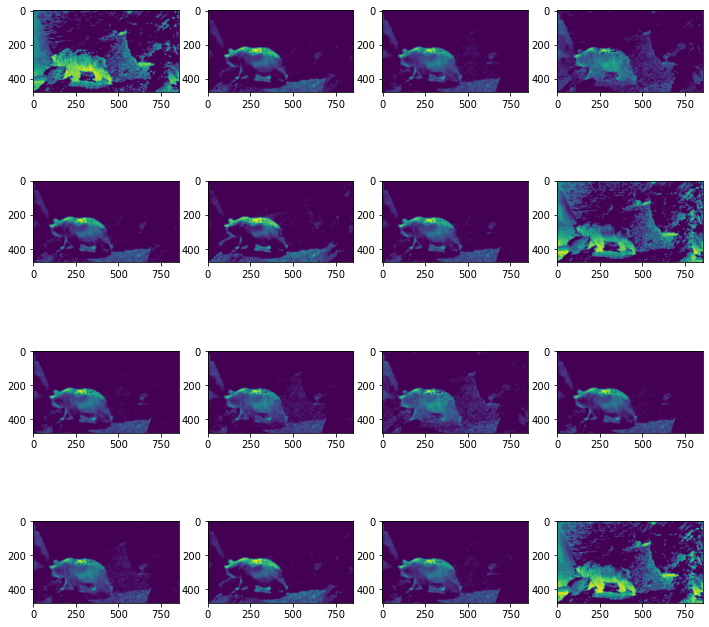

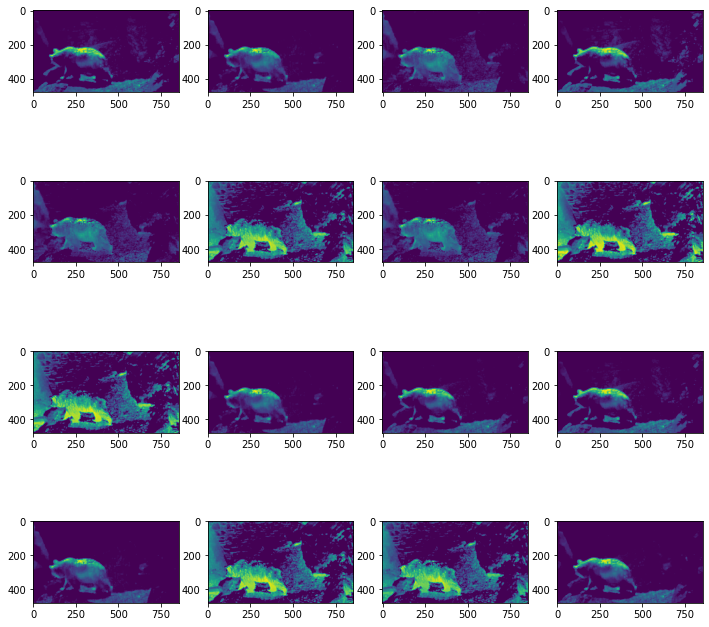

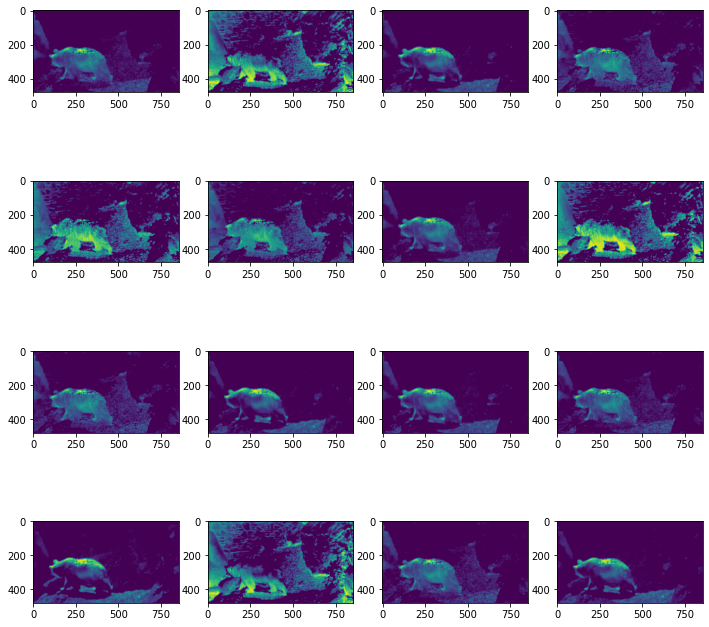

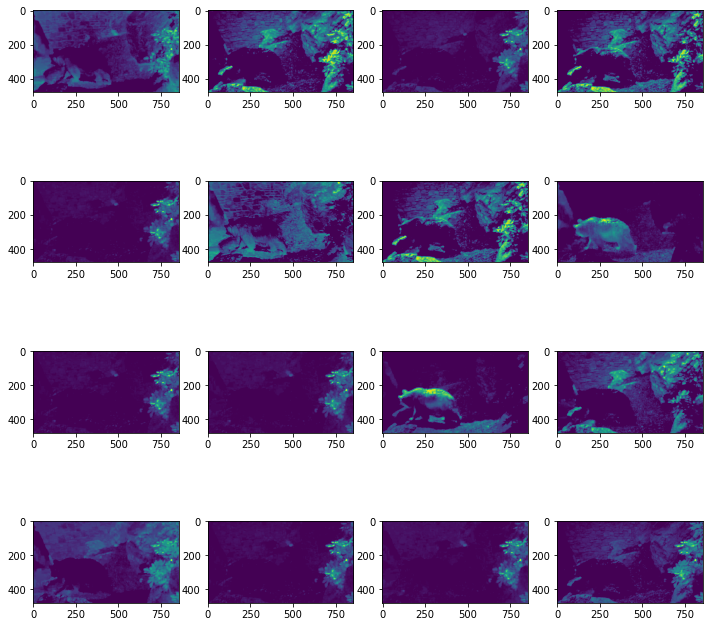

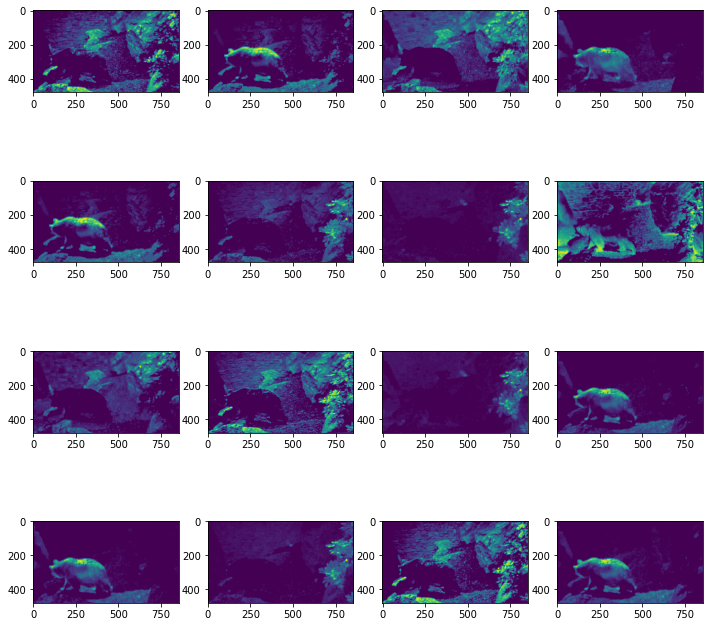

In [ ]:
#see output of FLIM
testimg = cv2.imread("/content/00000.jpg")

#transform image from RGB to LAB
testimg = rgb2lab(testimg)

#Normalize 
testimg = testimg/(np.array([[116], [500], [200]])).reshape(1, 1, 3)

testimg = testimg.astype(np.float32)

imgarray = torch.from_numpy(testimg).permute(2, 0, 1).float().unsqueeze(0)


out = model.feature_extractor.forward(imgarray)

print("output shape :", out.shape)

outnumpy = out.detach().numpy()

n_row = 4
n_col = 4

#drawing the bands obtained from FLIM
drawBandsfromImage(outnumpy[:, 0:16, :, :], n_row, n_col)

drawBandsfromImage(outnumpy[:, 16:32, :, :], n_row, n_col)

drawBandsfromImage(outnumpy[:, 32:64, :, :], n_row, n_col)

drawBandsfromImage(outnumpy[:, 64:96, :, :], n_row, n_col)

drawBandsfromImage(outnumpy[:, 96:128, :, :], n_row, n_col)